In [20]:
import pandas as pd
import sklearn
import statsmodels
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

## STEP 1 : 시계열 데이터 준비

In [21]:
data = pd.read_csv('005930.KS.csv', index_col='Date', parse_dates=True)
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-25,70100.0,70200.0,69600.0,69800.0,68122.117188,12986010
2022-03-28,69500.0,69900.0,69200.0,69700.0,68024.515625,12619289
2022-03-29,70000.0,70300.0,69800.0,70200.0,68512.507813,13686208
2022-03-30,70300.0,70500.0,69800.0,69900.0,68572.343750,12670187
2022-03-31,69900.0,70200.0,69600.0,69600.0,68278.039063,12510366
...,...,...,...,...,...,...
2023-03-20,61100.0,61200.0,60200.0,60200.0,60200.000000,9618009
2023-03-21,60500.0,60700.0,60100.0,60300.0,60300.000000,8318514
2023-03-22,61000.0,61200.0,60500.0,61100.0,61100.000000,8978591


In [22]:
# Time Series 생성
ts = data['Close']
ts

Date
2022-03-25    69800.0
2022-03-28    69700.0
2022-03-29    70200.0
2022-03-30    69900.0
2022-03-31    69600.0
               ...   
2023-03-20    60200.0
2023-03-21    60300.0
2023-03-22    61100.0
2023-03-23    62300.0
2023-03-24    63000.0
Name: Close, Length: 248, dtype: float64

## STEP 2 : 각종 전처리 수행

In [23]:
# 결측치 처리
ts[ts.isna()]
# 있을 시
# ts = ts.interpolate(method='time')  # 시간에 따라 결측치 보완

Series([], Name: Close, dtype: float64)

In [24]:
# 로그 변환
ts = np.log(ts)
ts

Date
2022-03-25    11.153389
2022-03-28    11.151956
2022-03-29    11.159104
2022-03-30    11.154821
2022-03-31    11.150520
                ...    
2023-03-20    11.005428
2023-03-21    11.007087
2023-03-22    11.020267
2023-03-23    11.039717
2023-03-24    11.050890
Name: Close, Length: 248, dtype: float64

## STEP 3 : 시계열 안정성 분석

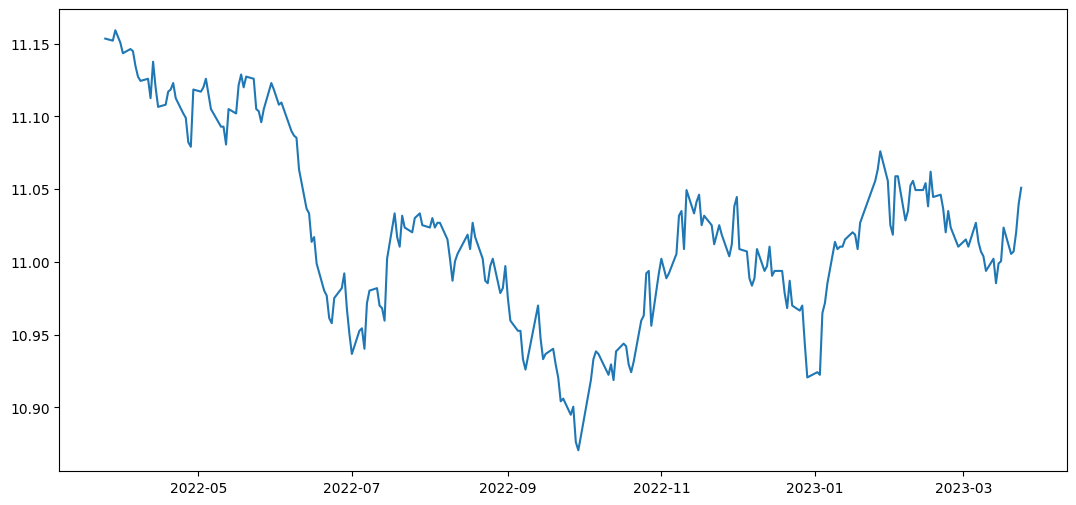

In [25]:
# 데이터 그래프로 확인
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13,6
plt.plot(ts)

In [26]:
# 정성적 그래프 분석

from cycler import cycler

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean() # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std() # 이동표준편차 시계열
    
    # 원본 시계열, 이동평균, 이동표준편차 plot
    fig,axe = plt.subplots(1,2,tight_layout=True)
    
    axe[0].set_title('Rolling Mean & original')
    line1 = axe[0].plot(timeseries, color='b', label='Original')
    line2 = axe[0].plot(rolmean, color='r', label='Rolling Mean')
    axe[0].legend(loc='best')
    
    axe[1].set_title('Standard Deviation')
    axe[1].plot(rolstd, color='g', label='Rolling std')
    axe[1].legend(loc='best')
    
    plt.show(block=False)

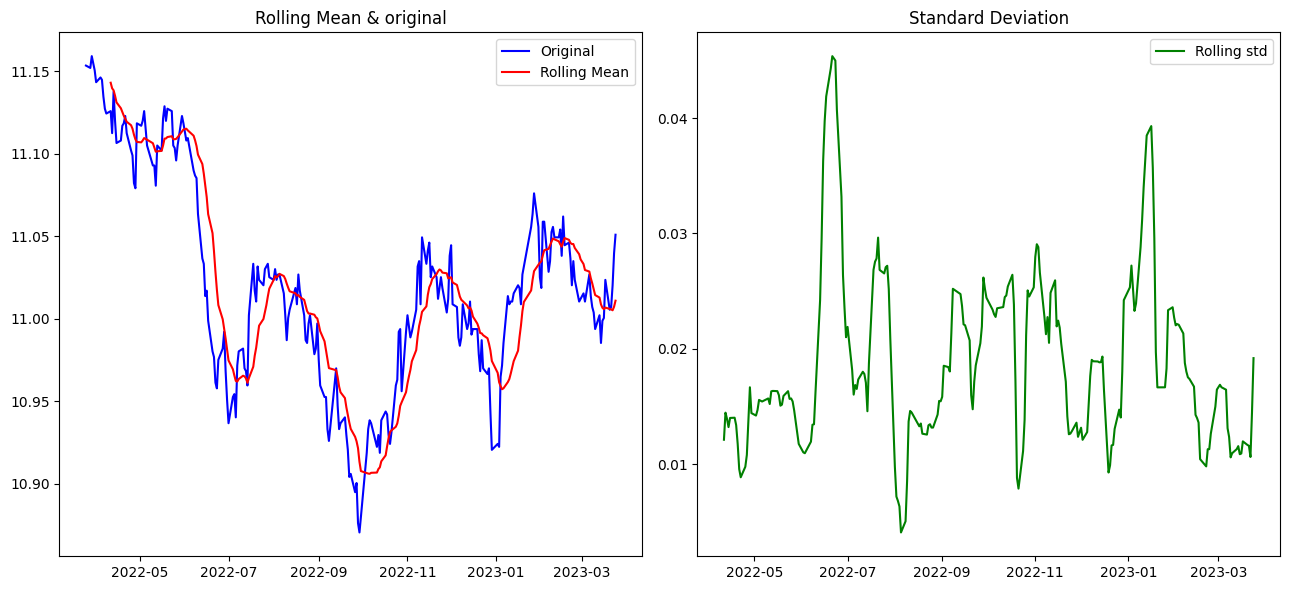

In [27]:
plot_rolling_statistics(ts,window=12)

In [28]:
#정량적 Augmented_dickey_fuller Test

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    
    # adfuller 메서드가 리턴한 결과를 정리하며 출력
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'% key] = value
    print(dfoutput)


In [29]:
augmented_dickey_fuller_test(ts)

Test Statistic                  -2.478053
p-value                          0.120906
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


## 시계열 분해 (time Series Decomposition)

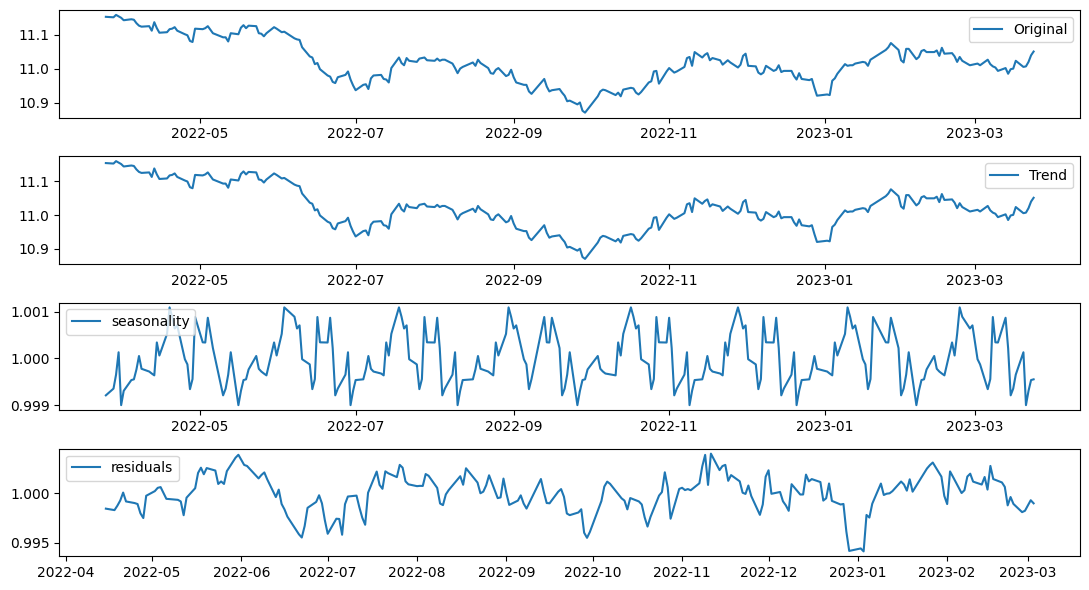

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, model='moultiplicative', period=30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal # 계절성 (패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams['figure.figsize'] = (11,6)
plt.subplot(411)
plt.plot(ts, label = 'Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts, label = 'Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label = 'seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label = 'residuals')
plt.legend(loc='best')
plt.tight_layout()

In [31]:
# residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Test Statistic                  -5.326575
p-value                          0.000005
#Lags Used                       0.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성

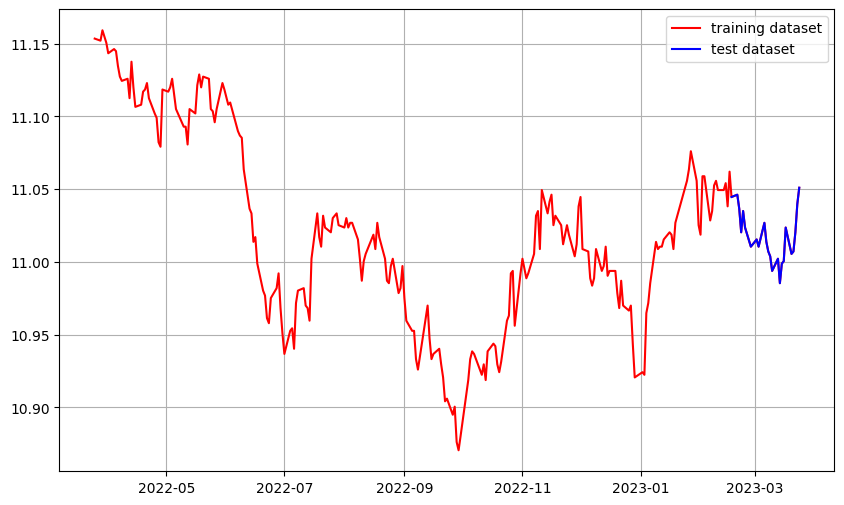

In [32]:
# 학습, 테스트 데이터셋 분리

train_data, test_data = ts[:int(len(ts)*0.9)],ts[int(len(ts)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts, c='r',label='training dataset')
plt.plot(test_data, c='b',label='test dataset')
plt.legend()
plt.show()

## STEP 5 : 적정 ARIMA 모수 찾기

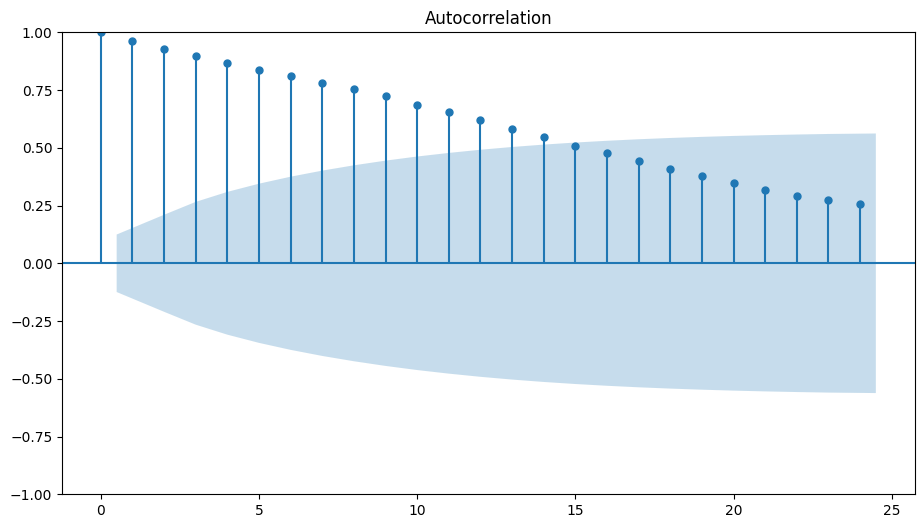

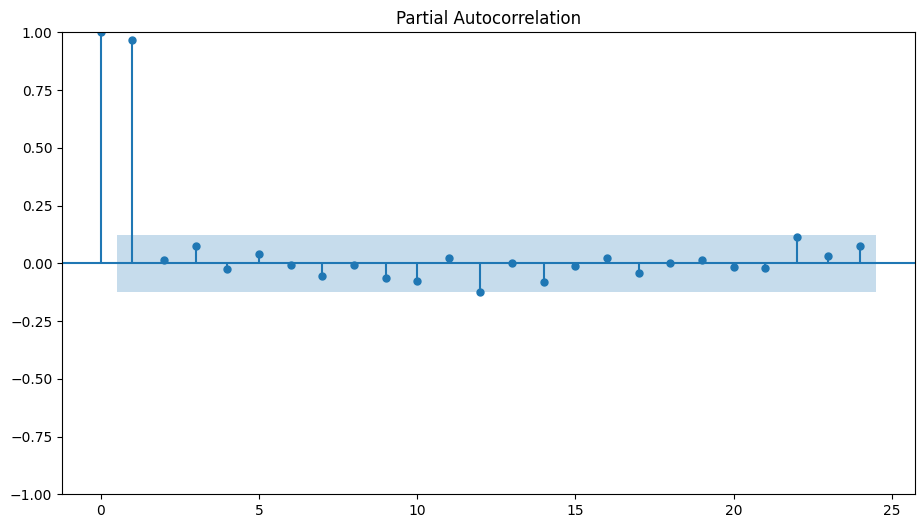

In [33]:
# ACF, PACR 그려보기 -> p,g구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts)
plot_pacf(ts)
plt.show()

Test Statistic                -1.258156e+01
p-value                        1.905412e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


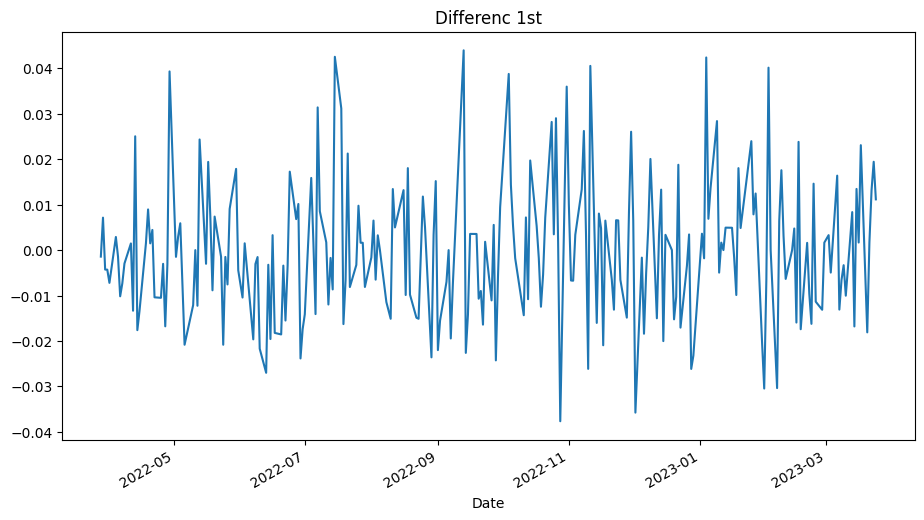

In [34]:
# 차분 안정성 확인 -> d 구하기

#1차 차분
diff_1 = ts.diff().iloc[1:]
diff_1.plot(title='Differenc 1st')

augmented_dickey_fuller_test(diff_1)

Test Statistic                -9.284316e+00
p-value                        1.227105e-15
#Lags Used                     9.000000e+00
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


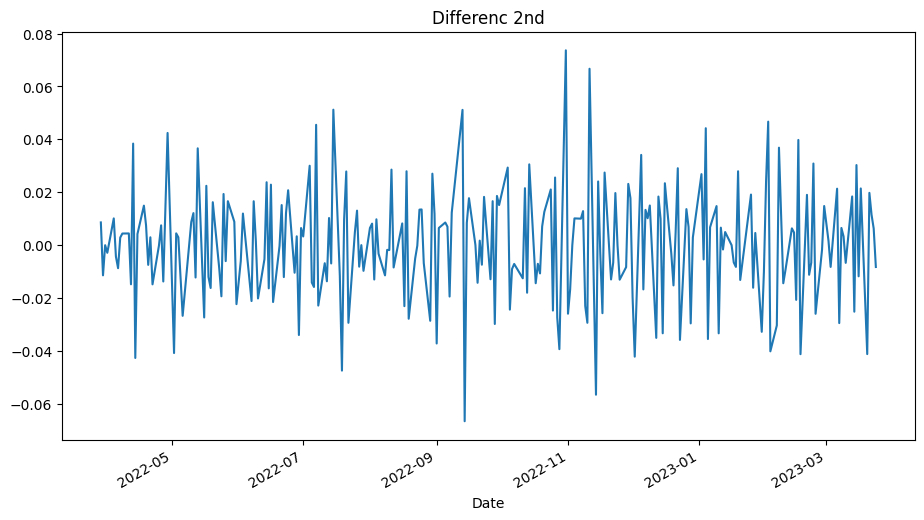

In [35]:
# 2차 차분

diff_2 = diff_1.diff().iloc[1:]
diff_2.plot(title='Differenc 2nd')

augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트

In [36]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train Model
model = ARIMA(train_data, order=(30,2,30))
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:               ARIMA(30, 2, 30)   Log Likelihood                 623.884
Date:                Sat, 25 Mar 2023   AIC                          -1125.767
Time:                        11:52:16   BIC                           -918.479
Sample:                             0   HQIC                         -1042.068
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8167      4.179     -0.195      0.845      -9.007       7.374
ar.L2         -0.6327      4.933     -0.128      0.898     -10.301       9.036
ar.L3         -0.5071      2.449     -0.207      0.8

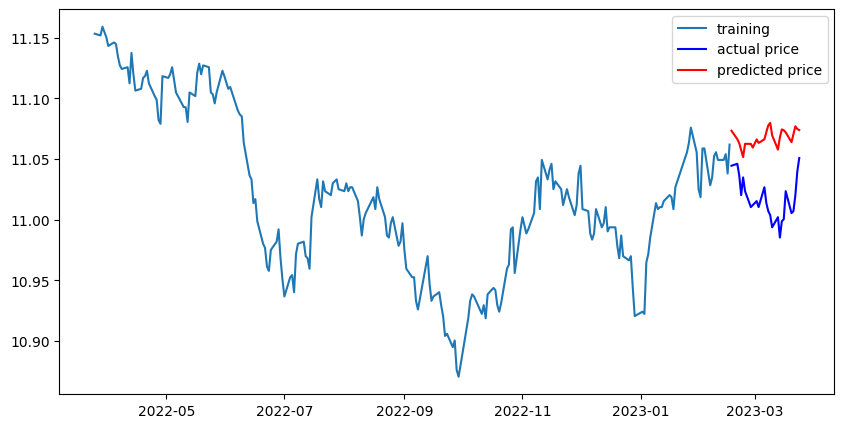

In [37]:
# 구간 데이터 예측

fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mse)
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc)-np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  11289760.584291732
MAE:  3155.739619265523
RMSE:  3360.0238963870083
MAPE: 5.21%


## STEP 7 : 다른 주식 종목 예측해 보기
---

### STEP 1 : 시계열 데이터 준비

In [39]:
# Time Series 생성
s = pd.read_csv('TSLA.csv',index_col='Date',parse_dates=True)
ts = s['Close']

ts.head()

Date
2022-03-23    333.036682
2022-03-24    337.973328
2022-03-25    336.880005
2022-03-28    363.946655
2022-03-29    366.523346
Name: Close, dtype: float64

### STEP 2 : 각종 전처리 수행

In [40]:
# 결측치 처리
ts[ts.isna()]
# 있을 시
# ts = ts.interpolate(method='time')  # 시간에 따라 결측치 보완

Series([], Name: Close, dtype: float64)

In [41]:
# 로그 변환
ts = np.log(ts)
ts

Date
2022-03-23    5.808253
2022-03-24    5.822967
2022-03-25    5.819727
2022-03-28    5.897007
2022-03-29    5.904062
                ...   
2023-03-17    5.193679
2023-03-20    5.210851
2023-03-21    5.286144
2023-03-22    5.253058
2023-03-23    5.258641
Name: Close, Length: 252, dtype: float64

### STEP 3 : 시계열 안정성 분석

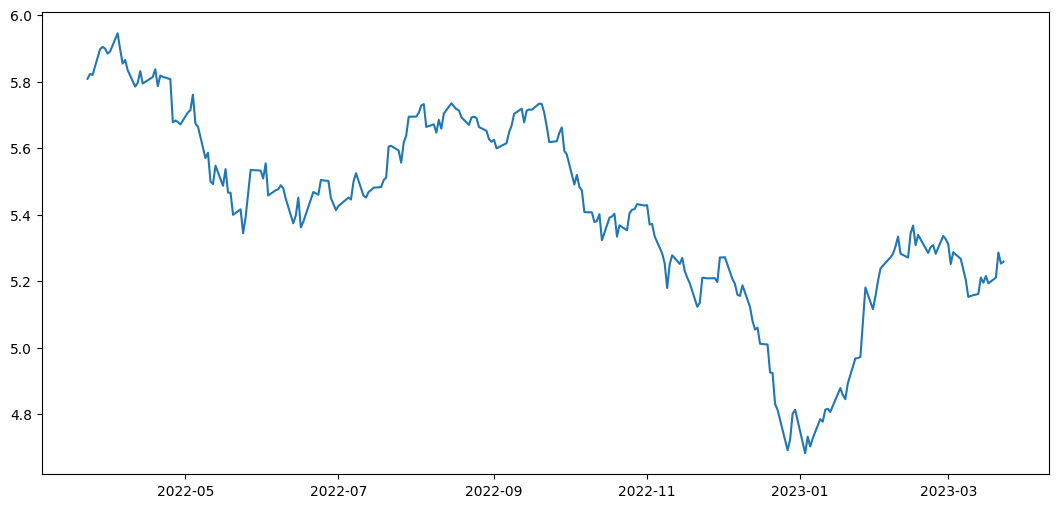

In [42]:
# 데이터 그래프로 확인
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13,6
plt.plot(ts)

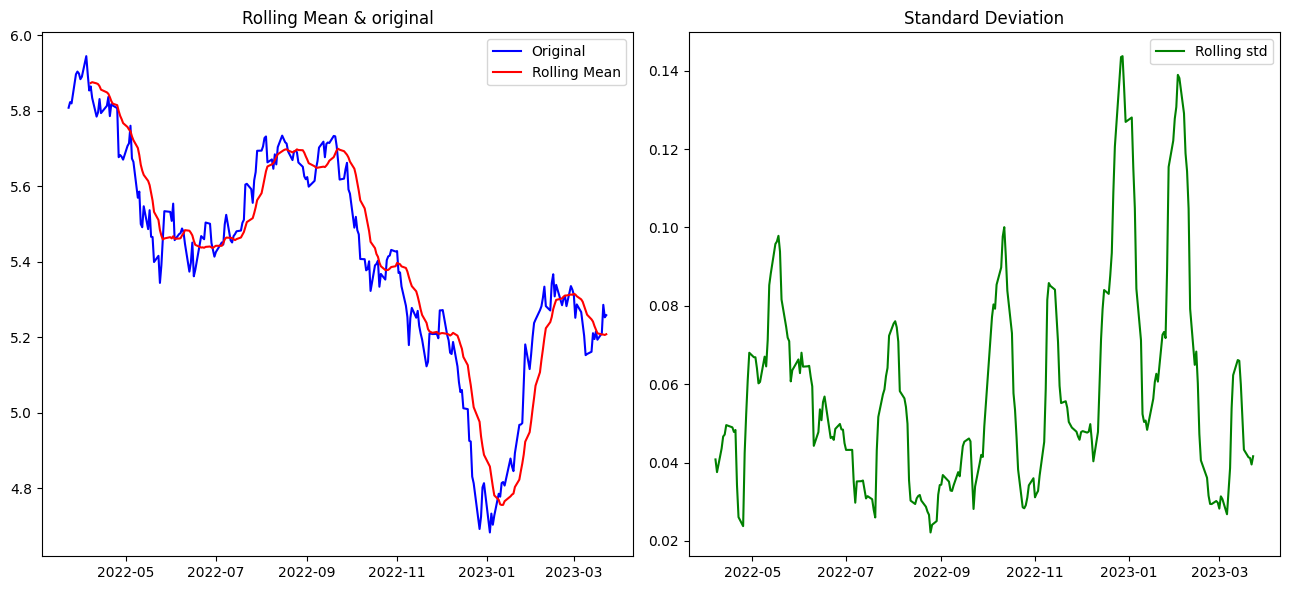

In [43]:
# 정성적 그래프 분석
plot_rolling_statistics(ts,window=12)

In [44]:
#정량적 Augmented_dickey_fuller Test
augmented_dickey_fuller_test(ts)

Test Statistic                  -2.345130
p-value                          0.157825
#Lags Used                       9.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


### 시계열 분해 (time Series Decomposition)

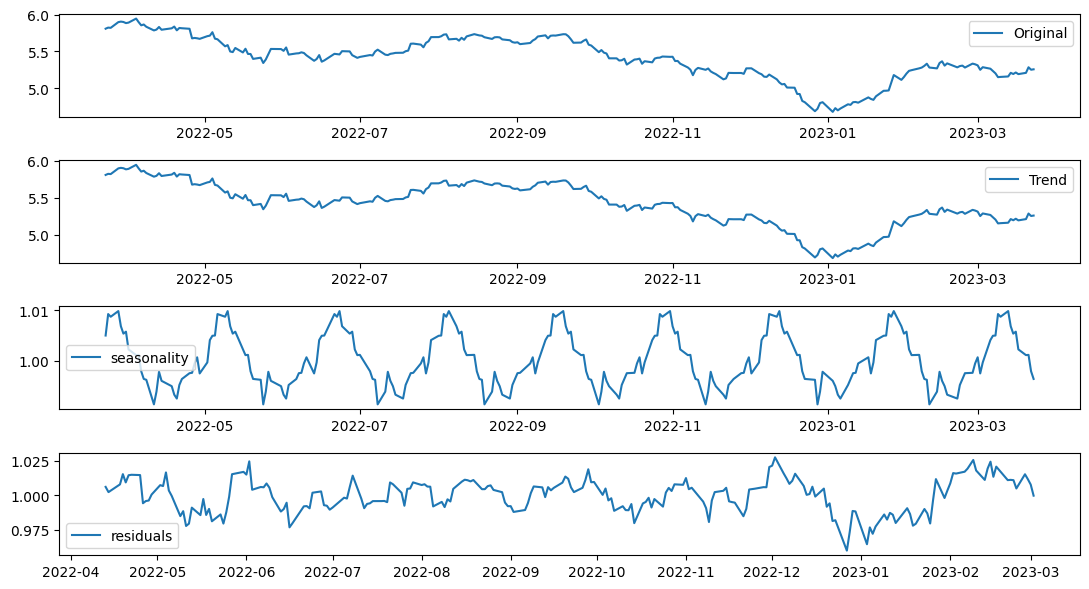

In [45]:
decomposition = seasonal_decompose(ts, model='moultiplicative', period=30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal # 계절성 (패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams['figure.figsize'] = (11,6)
plt.subplot(411)
plt.plot(ts, label = 'Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts, label = 'Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label = 'seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label = 'residuals')
plt.legend(loc='best')
plt.tight_layout()

In [46]:
# residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Test Statistic                  -4.263585
p-value                          0.000513
#Lags Used                       9.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


### STEP 4 : 학습, 테스트 데이터셋 생성

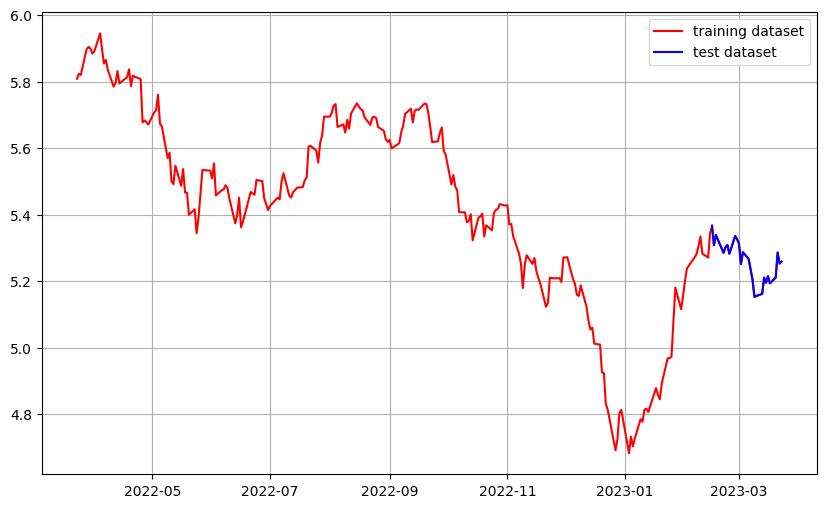

In [47]:
# 학습, 테스트 데이터셋 분리

train_data, test_data = ts[:int(len(ts)*0.9)],ts[int(len(ts)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts, c='r',label='training dataset')
plt.plot(test_data, c='b',label='test dataset')
plt.legend()
plt.show()

### STEP 5 : 적정 ARIMA 모수 찾기

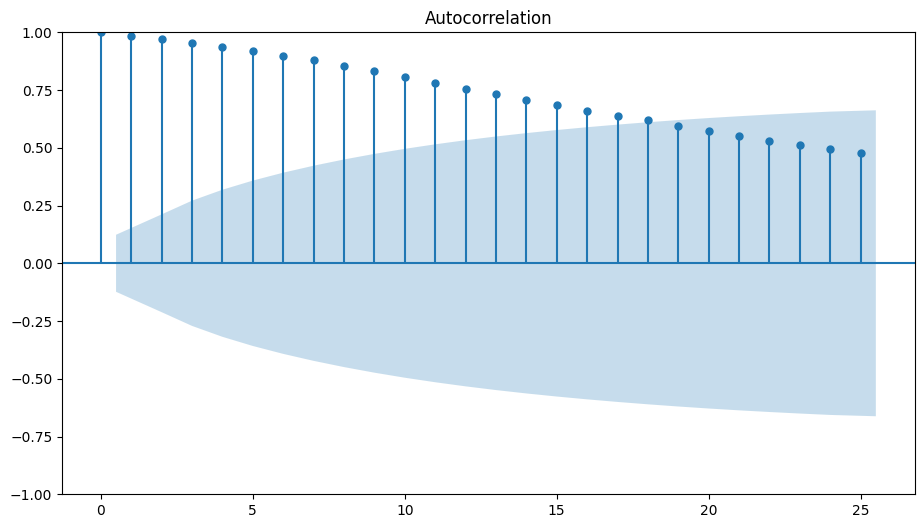

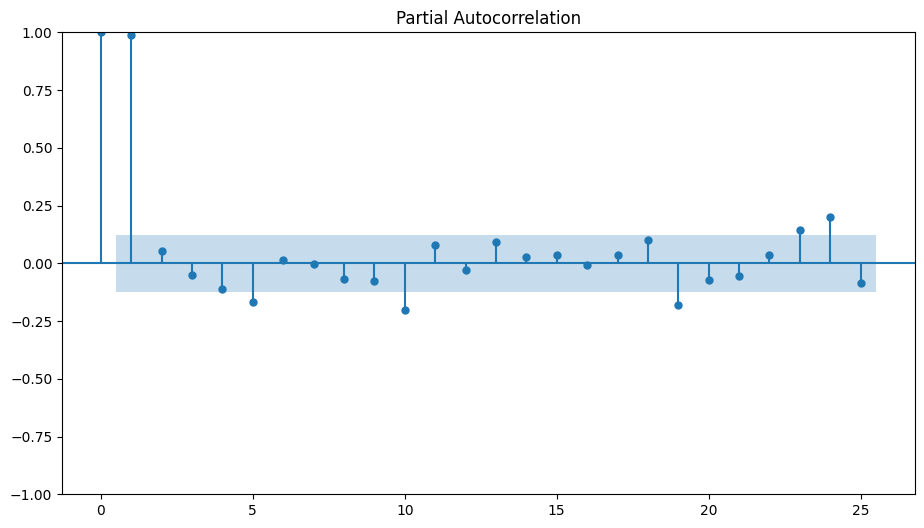

In [48]:
# ACF, PACR 그려보기 -> p,g구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts)
plot_pacf(ts)
plt.show()

ACF는 천천히 감소하는 형태를 띄며 PACF는 1~3사이에서 급격하게 감소하는 형태이다.

이는 AR그래프 형태를 띔, 따라서 이동평균을 무시하고 q를 1~3사이로 설정하는 것이 좋겠다

Test Statistic                  -3.614850
p-value                          0.005483
#Lags Used                       8.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


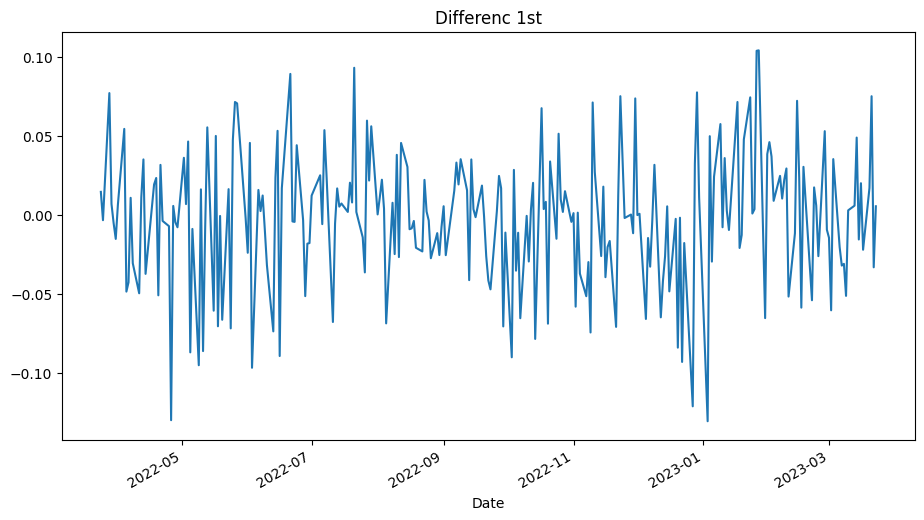

In [49]:
# 차분 안정성 확인 -> d 구하기

#1차 차분
diff_1 = ts.diff().iloc[1:]
diff_1.plot(title='Differenc 1st')

augmented_dickey_fuller_test(diff_1)

### STEP 6 : ARIMA 모델 훈련과 테스트

In [56]:
# Build and Train Model
model = ARIMA(train_data, order=(30,1,12))
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:               ARIMA(30, 1, 12)   Log Likelihood                 409.143
Date:                Sat, 25 Mar 2023   AIC                           -732.287
Time:                        11:59:12   BIC                           -585.395
Sample:                             0   HQIC                          -673.001
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0520      8.438     -0.006      0.995     -16.590      16.486
ar.L2         -0.0294      6.022     -0.005      0.996     -11.832      11.773
ar.L3          0.0143      4.339      0.003      0.9

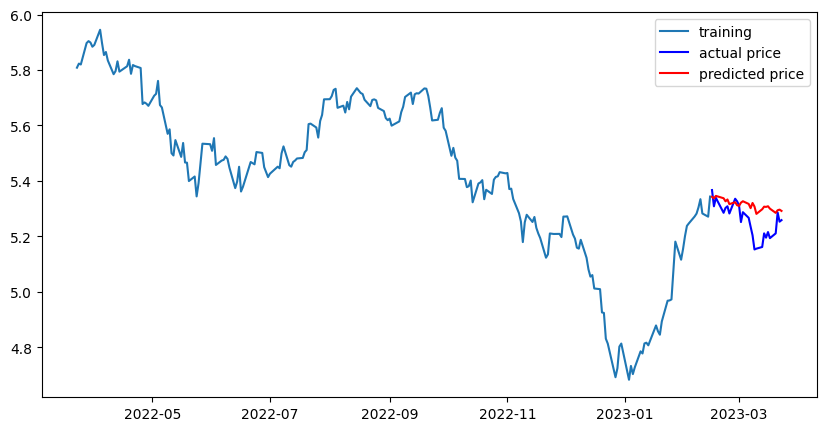

In [57]:
# 구간 데이터 예측

fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [58]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mse)
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc)-np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  198.97068388656223
MAE:  11.498394990072951
RMSE:  14.105696859303414
MAPE: 6.23%


## 한개 더

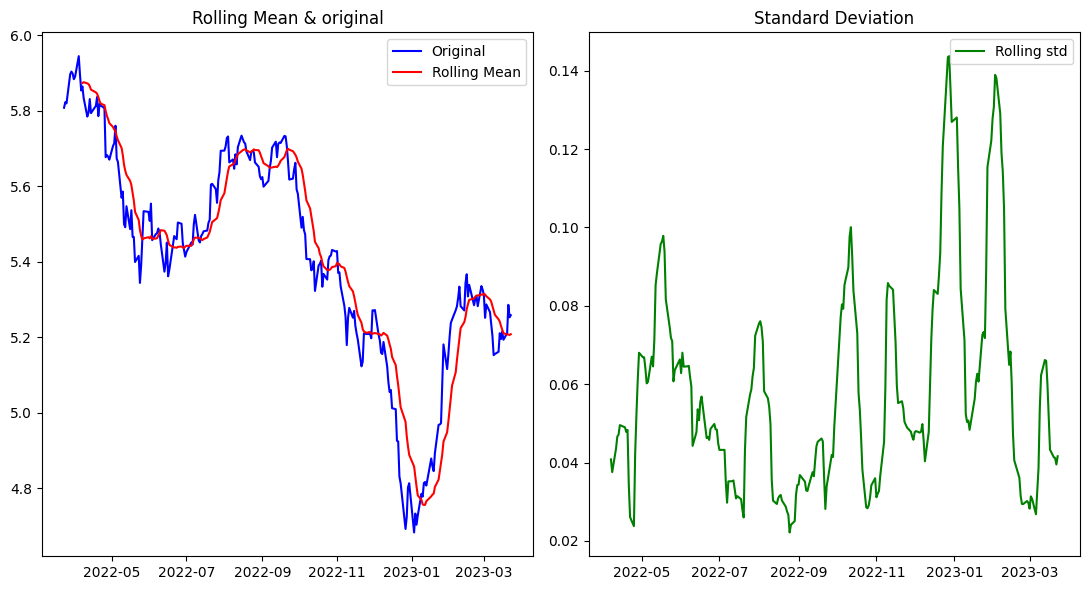

In [62]:
s = pd.read_csv('TSLA.csv',index_col='Date',parse_dates=True)
ts = s['Close']

ts[ts.isna()]

ts = np.log(ts)

plot_rolling_statistics(ts,window=12)

In [63]:
augmented_dickey_fuller_test(ts)

Test Statistic                  -2.345130
p-value                          0.157825
#Lags Used                       9.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


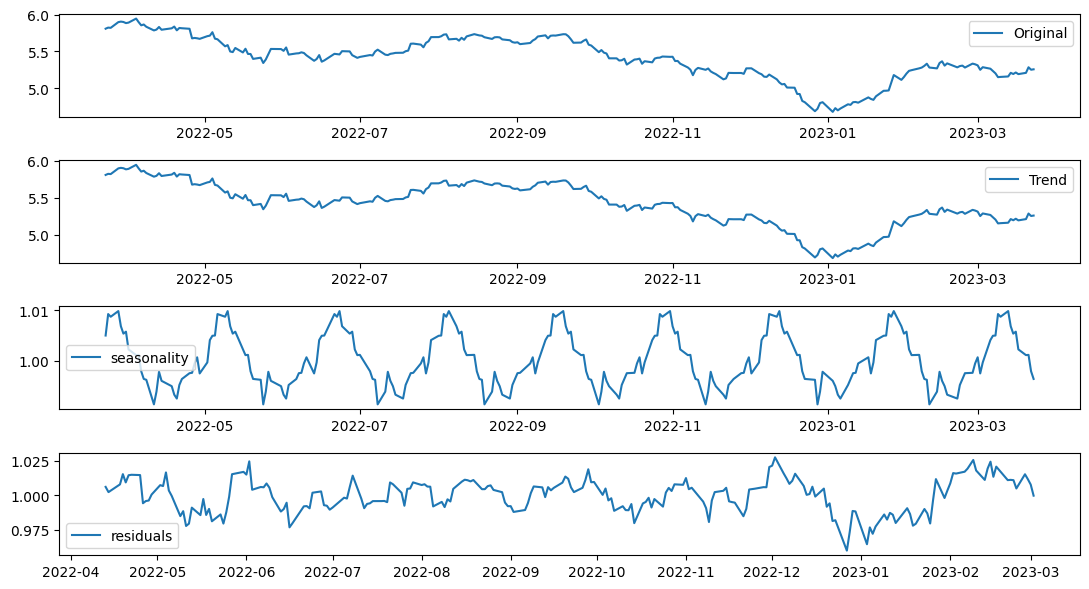

In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, model='moultiplicative', period=30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal # 계절성 (패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams['figure.figsize'] = (11,6)
plt.subplot(411)
plt.plot(ts, label = 'Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts, label = 'Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label = 'seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label = 'residuals')
plt.legend(loc='best')
plt.tight_layout()

In [65]:
# residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Test Statistic                  -4.263585
p-value                          0.000513
#Lags Used                       9.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


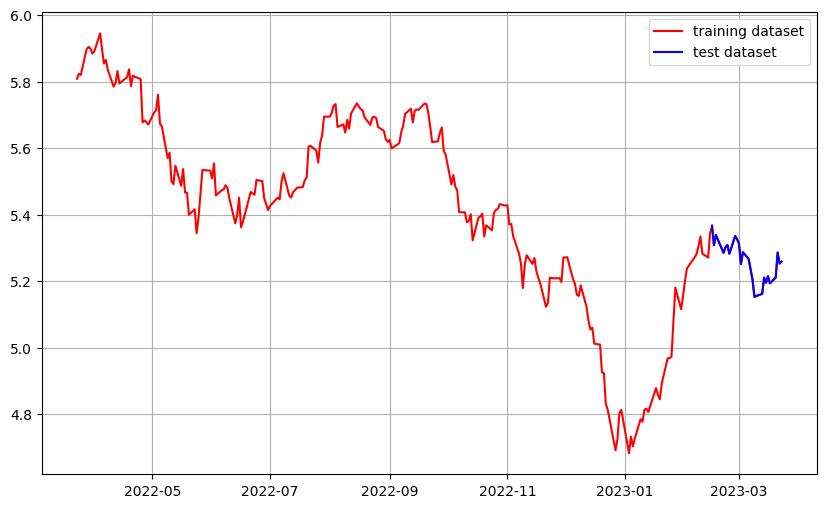

In [66]:
# 학습, 테스트 데이터셋 분리

train_data, test_data = ts[:int(len(ts)*0.9)],ts[int(len(ts)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts, c='r',label='training dataset')
plt.plot(test_data, c='b',label='test dataset')
plt.legend()
plt.show()

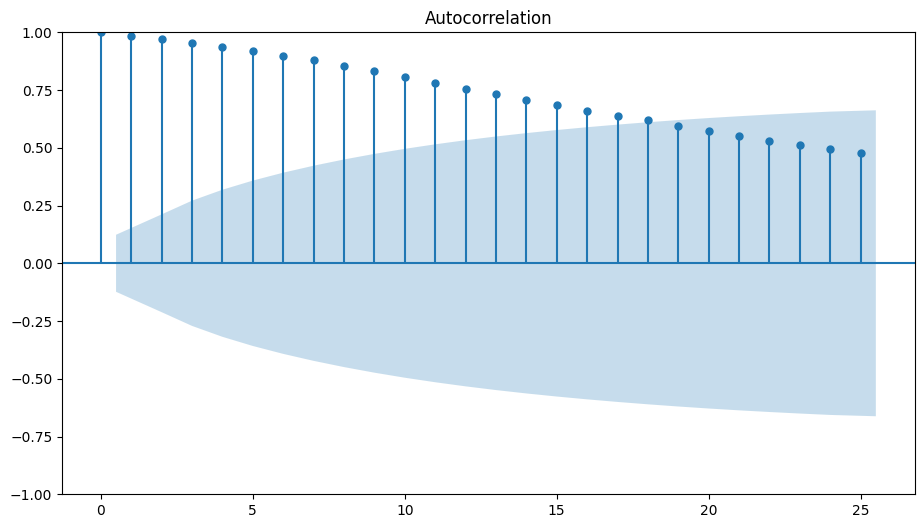

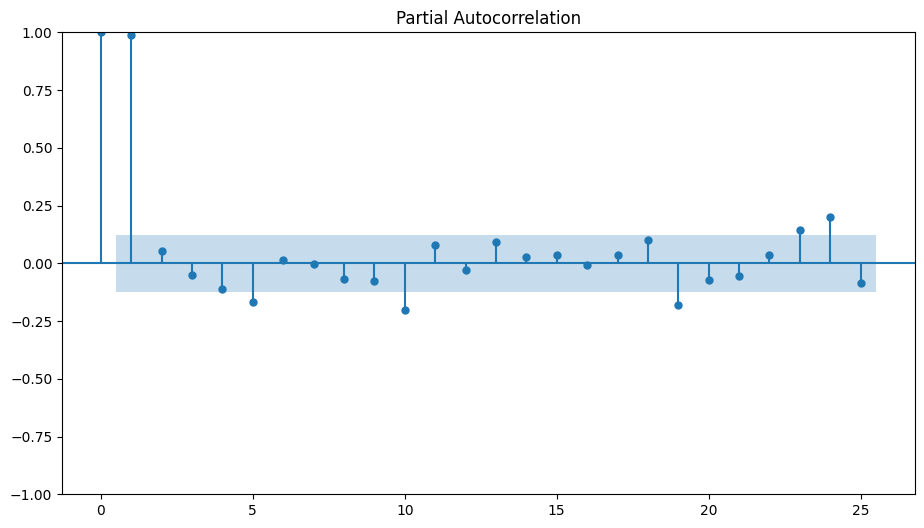

In [67]:
# ACF, PACR 그려보기 -> p,g구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts)
plot_pacf(ts)
plt.show()

Test Statistic                  -3.614850
p-value                          0.005483
#Lags Used                       8.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


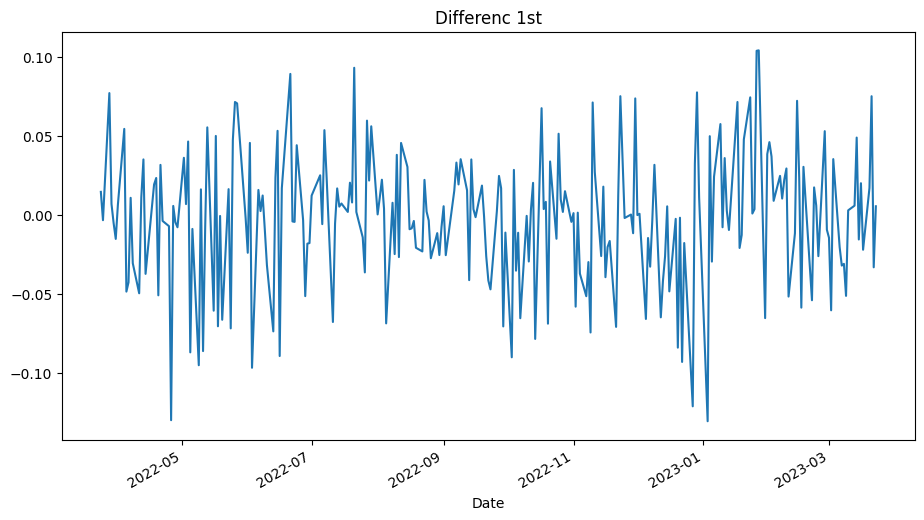

In [68]:
# 차분 안정성 확인 -> d 구하기

#1차 차분
diff_1 = ts.diff().iloc[1:]
diff_1.plot(title='Differenc 1st')

augmented_dickey_fuller_test(diff_1)

In [69]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train Model
model = ARIMA(train_data, order=(30,2,30))
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:               ARIMA(30, 2, 30)   Log Likelihood                 408.136
Date:                Sat, 25 Mar 2023   AIC                           -694.272
Time:                        12:19:37   BIC                           -486.162
Sample:                             0   HQIC                          -610.269
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6789     65.625     -0.010      0.992    -129.301     127.943
ar.L2         -0.3485     42.819     -0.008      0.994     -84.272      83.575
ar.L3         -0.1721     35.147     -0.005      0.9

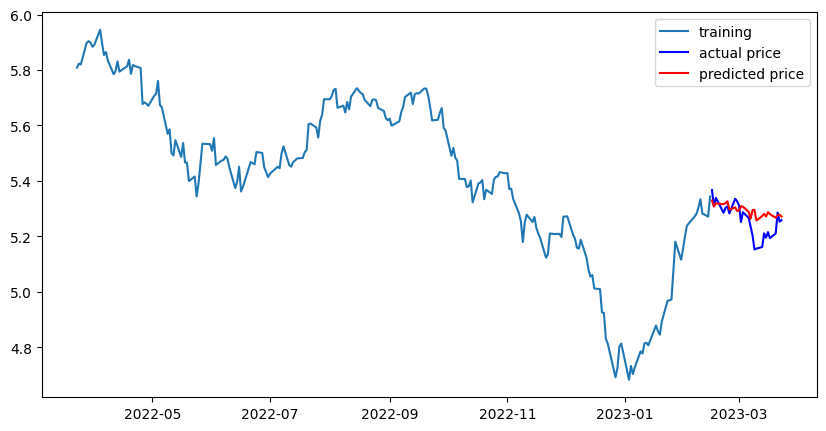

In [70]:
# 구간 데이터 예측

fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mse)
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc)-np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  122.91064311836915
MAE:  8.87873660079884
RMSE:  11.086507255144388
MAPE: 4.80%


# 회고

대학 전공 수준의 통계학을 맛본 것 같습니다.

시계열 데이터의 trend, seasonality 등을 분석 해 차분을 구하고 데이터에 고려해주어
residual 데이터가 안정성을 띄도록 하여 보다 명확한 예측을 위기위해 작업해주는 것들이란 것으로 이해가 되었습니다.

하지만 의아한 것은 ACF와 PACF 그래프 함수를 보고 어림잡아 p와 q를 구하는 작업만으로는 좋은 mape를 얻을 수 없었던 것인데,

지금까지 했던 전처리와 시각화로 얻은 p,q가 아닌 실험적으로 p,d,q를 대입해가며 좋은 예측값을 얻는 다면 trend와 seasonality를 고려한 차분을 
해줄 필요가 있을 까라는 생각이 들었습니다. 

그래서 그 대안으로 데이터 별로 다르겠지만 차분을 고려하고 안정하다라고 판단되는 그래프들의 종류
에 따라 값이 잘나오는 p,d,q를 표로 정리해둔다면 시간을 절약하고, 이것또한 통계적 분석의 한 종류가 될 것같다는 생각이 들었습니다.